In [1]:
 !pip install pandas_datareader

In [4]:
 !pip install pmdarima

In [29]:
import os
import pandas as pd
import pandas_datareader as pdr

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima

import seaborn as sns
plt.style.use('seaborn-whitegrid')

import itertools

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv('AirPassengers.csv')
data = data.rename(columns={'Month':'month', '#Passengers':'passengers'})
data['month'] = pd.to_datetime(data['month'])
data = data.set_index('month')
data.head()

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


### Box-Jenkins Arima Procedure

#### * Data preprocessing 

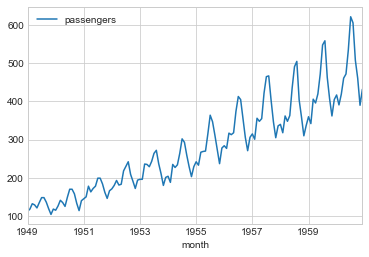

In [7]:
fig = data.plot()

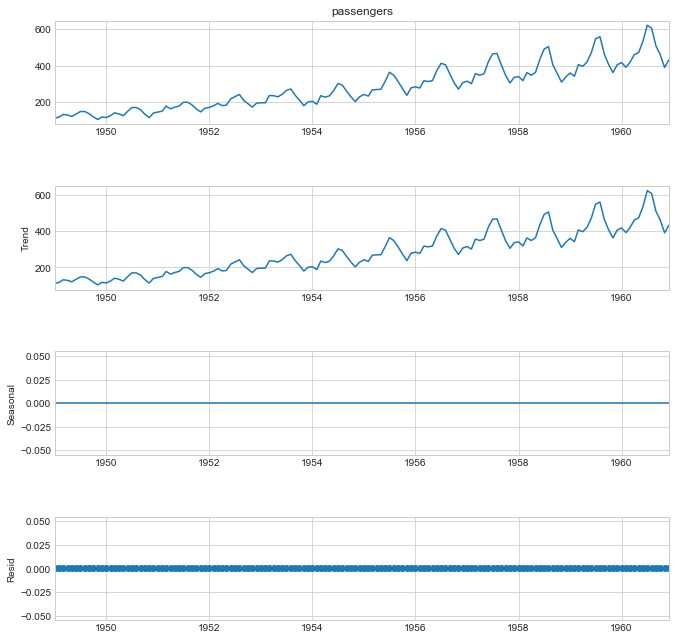

In [14]:
decomposition = sm.tsa.seasonal_decompose(data['passengers'], model='additive', period=1)
fig = decomposition.plot()
fig.set_size_inches(10,10)
plt.show()

In [15]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

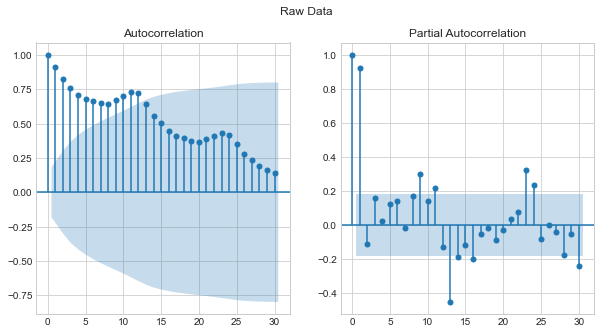

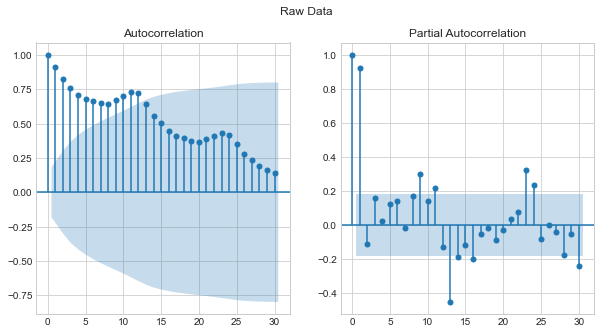

In [23]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(train_data.values.squeeze(), lags=30, ax=ax[1])                         

#### Nonstationary한 데이터임을 확인 -> differencing 수행

In [25]:
diff_train_data = train_data.copy()
diff_train_data = diff_train_data['passengers'].diff()
diff_train_data = diff_train_data.dropna() # 마지막 짝 안맞는거 제거

print('##### Raw data #####')
print(train_data)
print('##### differenced data #####')
print(diff_train_data)

##### Raw data #####
            passengers
month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1958-03-01         362
1958-04-01         348
1958-05-01         363
1958-06-01         435
1958-07-01         491

[115 rows x 1 columns]
##### differenced data #####
month
1949-02-01     6.0
1949-03-01    14.0
1949-04-01    -3.0
1949-05-01    -8.0
1949-06-01    14.0
              ... 
1958-03-01    44.0
1958-04-01   -14.0
1958-05-01    15.0
1958-06-01    72.0
1958-07-01    56.0
Name: passengers, Length: 114, dtype: float64


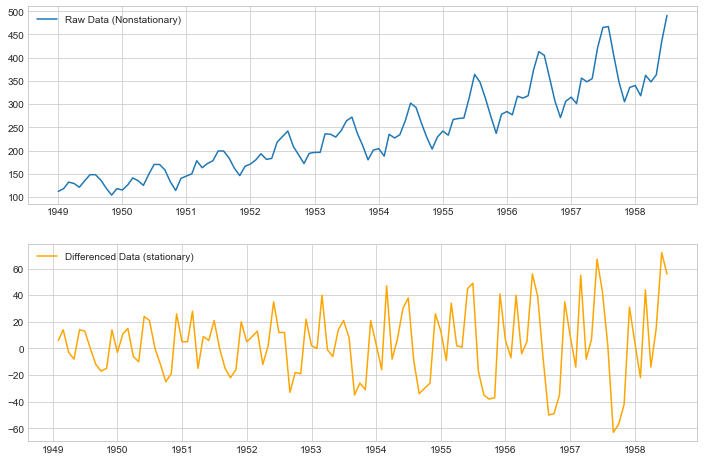

In [26]:
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.plot(train_data['passengers'])
plt.legend(['Raw Data (Nonstationary)'])
plt.subplot(212)
plt.plot(diff_train_data, 'orange')
plt.legend(['Differenced Data (stationary)'])
plt.show()

C:\Users\gilmo\anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


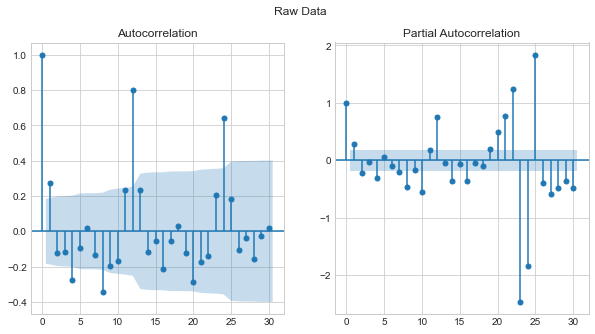

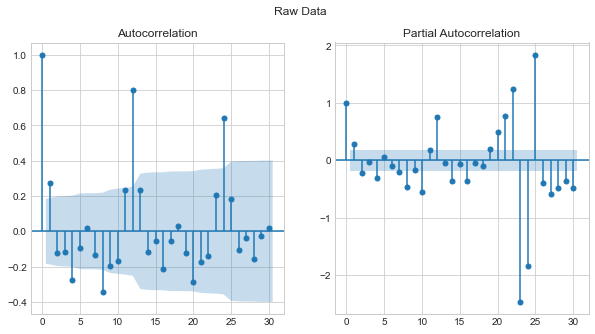

In [27]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
fig.suptitle('Raw Data')
sm.graphics.tsa.plot_acf(diff_train_data.values.squeeze(), lags=30, ax=ax[0])
sm.graphics.tsa.plot_pacf(diff_train_data.values.squeeze(), lags=30, ax=ax[1])                         

#### acf: 소멸하는 sin함수 형태, pacf: p을 1로 설정

In [30]:
model = ARIMA(train_data.values, order=(1,1,0))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -531.720
Method:                       css-mle   S.D. of innovations             25.659
Date:                Sun, 06 Mar 2022   AIC                           1069.440
Time:                        19:17:43   BIC                           1077.649
Sample:                             1   HQIC                          1072.771
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5123      3.329      1.055      0.291      -3.012      10.037
ar.L1.D.y      0.2803      0.091      3.077      0.002       0.102       0.459
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            3.5681           +0.0000j            3.5681            0.0000
-----------------------------------------------------------------------------
"""

In [34]:
print('Examples of parameter combinations for seasonal arima.....')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))

aic = []
for i in pdq:
    model = ARIMA(train_data.values, order=(i))
    model_fit = model.fit()
    print(f'ARIMA: {i} >> AIC: {round(model_fit.aic,2)}')
    aic.append(round(model_fit.aic,2))

Examples of parameter combinations for seasonal arima.....
ARIMA: (0, 1, 0) >> AIC: 1076.52
ARIMA: (0, 1, 1) >> AIC: 1064.62
ARIMA: (0, 1, 2) >> AIC: 1061.08
ARIMA: (1, 1, 0) >> AIC: 1069.44
ARIMA: (1, 1, 1) >> AIC: 1058.83
ARIMA: (1, 1, 2) >> AIC: 1046.05
ARIMA: (2, 1, 0) >> AIC: 1066.2
ARIMA: (2, 1, 1) >> AIC: 1045.66
ARIMA: (2, 1, 2) >> AIC: 1047.19


### ARIMA: (2, 1, 1) >> AIC: 1045.66 best


In [35]:
optimal = [(pdq[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[((2, 1, 1), 1045.66)]

In [36]:
model_opt = ARIMA(train_data.values, order=optimal[0][0])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  114
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -517.830
Method:                       css-mle   S.D. of innovations             22.317
Date:                Sun, 06 Mar 2022   AIC                           1045.660
Time:                        19:31:04   BIC                           1059.341
Sample:                             1   HQIC                          1051.212
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5600      0.163     15.753      0.000       2.241       2.878
ar.L1.D.y      1.0890      0.085     12.816      0.000       0.922       1.256
ar.L2.D.y     -0.4730      0.086     -5.528      0.000      -0.641      -0.305
ma.L1.D.y     -0.9999      0.040    -25.219      0.000      -1.078      -0.922
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1512           -0.8882j            1.4541           -0.1046
AR.2            1.1512           +0.8882j            1.4541            0.1046
MA.1            1.0001           +0.0000j            1.0001            0.0000
-----------------------------------------------------------------------------
"""

### use model to forecast - arima

In [55]:
prediction = model_opt_fit.forecast(len(test_data))
predicted_value = prediction[0]
predicted_lb = prediction[2][:,0]
predicted_ub = prediction[2][:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

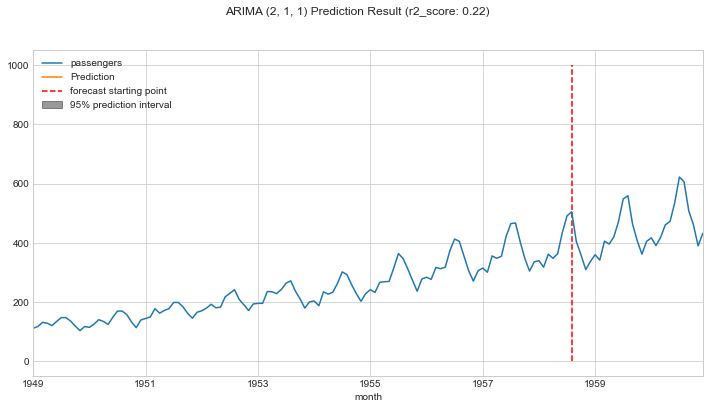

In [60]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax);
ax.vlines('1958-08-01', 0, 1000, linestyle='--', color='r', label='forecast starting point');
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_ub, predicted_lb, color='k', alpha=0.4, label= '95% prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA {optimal[0][0]} Prediction Result (r2_score: {round(r2,2)})')
plt.show()

### SARIMA 

In [64]:
print('Examples of parameter combinations for seasonal Arima')
p = range(0,3)
d = range(1,2)
q = range(0,3)
pdq = list(itertools.product(p,d,q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

aic = []
params = []
for i in pdq:
    for j in seasonal_pdq:
        try:
            model = SARIMAX(train_data.values, order=(i), seasonal_order=(j))
            model_fit = model.fit()
            print(f'SARIMA: {i}{j} >> AIC: {round(model_fit.aic,2)}')
            aic.append(round(model_fit.aic,2))
            params.append((i, j))
        except:
            continue

Examples of parameter combinations for seasonal Arima
SARIMA: (0, 1, 0)(0, 1, 0, 12) >> AIC: 757.83
SARIMA: (0, 1, 0)(0, 1, 1, 12) >> AIC: 756.99
SARIMA: (0, 1, 0)(0, 1, 2, 12) >> AIC: 758.83
SARIMA: (0, 1, 0)(1, 1, 0, 12) >> AIC: 756.96
SARIMA: (0, 1, 0)(1, 1, 1, 12) >> AIC: 758.92
SARIMA: (0, 1, 0)(1, 1, 2, 12) >> AIC: 754.42
SARIMA: (0, 1, 0)(2, 1, 0, 12) >> AIC: 758.87
SARIMA: (0, 1, 0)(2, 1, 1, 12) >> AIC: 760.73
SARIMA: (0, 1, 0)(2, 1, 2, 12) >> AIC: 754.92
SARIMA: (0, 1, 1)(0, 1, 0, 12) >> AIC: 756.01
SARIMA: (0, 1, 1)(0, 1, 1, 12) >> AIC: 756.38
SARIMA: (0, 1, 1)(0, 1, 2, 12) >> AIC: 757.65
SARIMA: (0, 1, 1)(1, 1, 0, 12) >> AIC: 756.17
SARIMA: (0, 1, 1)(1, 1, 1, 12) >> AIC: 758.11
SARIMA: (0, 1, 1)(1, 1, 2, 12) >> AIC: 751.73
SARIMA: (0, 1, 1)(2, 1, 0, 12) >> AIC: 757.99
SARIMA: (0, 1, 1)(2, 1, 1, 12) >> AIC: 753.78
SARIMA: (0, 1, 1)(2, 1, 2, 12) >> AIC: 761.17
SARIMA: (0, 1, 2)(0, 1, 0, 12) >> AIC: 757.78
SARIMA: (0, 1, 2)(0, 1, 1, 12) >> AIC: 758.04
SARIMA: (0, 1, 2)(0, 1, 2,

In [65]:
optimal = [(params[i], j) for i, j in enumerate(aic) if j == min(aic)]
optimal

[(((1, 1, 1), (2, 1, 2, 12)), 14.0)]

In [73]:
model_opt = SARIMAX(train_data.values, order=optimal[0][0][0], seasonal_order = optimal[0][0][1])
model_opt_fit = model_opt.fit()
model_opt_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  115
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2], 12)   Log Likelihood                   0.000
Date:                                 Sun, 06 Mar 2022   AIC                             14.000
Time:                                         20:33:28   BIC                             32.375
Sample:                                              0   HQIC                            21.441
                                                 - 115                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8925         -0       -inf      0.000       0.893       0.893
ma.L1         -0.9835   1.95e-09  -5.03e+08      0.000      -0.983      -0.983
ar.S.L12     2.18e-05   3.24e-11   6.73e+05      0.000    2.18e-05    2.18e-05
ar.S.L24       1.0000   1.45e-10    6.9e+09      0.000       1.000       1.000
ma.S.L12    6.432e-05      2e-09   3.22e+04      0.000    6.43e-05    6.43e-05
ma.S.L24      -0.9999   5.02e-10  -1.99e+09      0.000      -1.000      -1.000
sigma2         8.7929   1.07e-08   8.25e+08      0.000       8.793       8.793
===================================================================================
Ljung-Box (L1) (Q):                    nan   Jarque-Bera (JB):                38.25
Prob(Q):                               nan   Prob(JB):                         0.00
Heteroskedasticity (H):                nan   Skew:                             0.00
Prob(H) (two-sided):                   nan   Kurtosis:                         0.00
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

### use sarima to forecast

In [97]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='month', length=144, freq=None)

In [74]:
prediction = model_opt_fit.get_forecast(len(test_data))
predicted_value = prediction.predicted_mean
predicted_ub = prediction.conf_int()[:,0]
predicted_lb = prediction.conf_int()[:,1]
predict_index = list(test_data.index)
r2 = r2_score(test_data, predicted_value)

ValueError: x and y must have same first dimension, but have shapes (144,) and (29,)

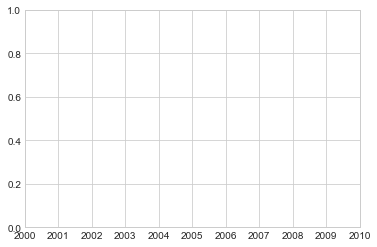

In [98]:
plt.plot(data.index, predicted_value)

In [85]:
data

,passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


In [93]:
predicted_value.plot

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

In [ ]:
ax = data.plot(label='observed', color='#006699')
predicted_value.plot(ax=ax, label='predicted', alpha=.7, color='#ff0066')

ax.vlines('1958-08-01', 0, 700, linestyles='--', color='r', label='Start of forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='95% prediction interbal')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]}, prediction result (r2 score: {round(r2,2)})')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

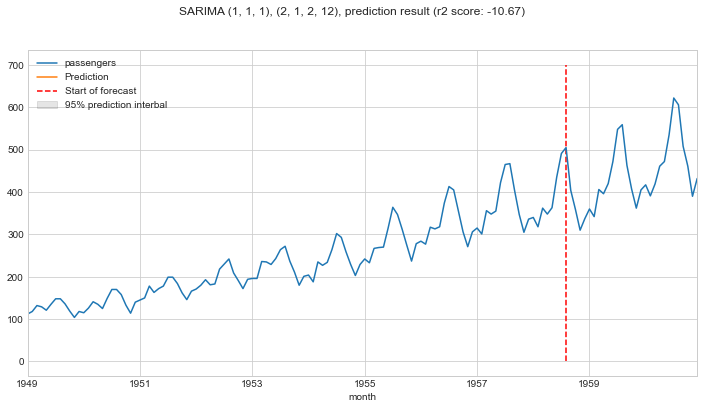

In [90]:
fig, ax = plt.subplots(figsize=(12,6))
data.plot(ax=ax)
ax.vlines('1958-08-01', 0, 700, linestyles='--', color='r', label='Start of forecast')
ax.plot(predict_index, predicted_value, label = 'Prediction')
ax.fill_between(predict_index, predicted_lb, predicted_ub, color='k', alpha=0.1, label='95% prediction interbal')
ax.legend(loc='upper left')
plt.suptitle(f'SARIMA {optimal[0][0][0]}, {optimal[0][0][1]}, prediction result (r2 score: {round(r2,2)})')
plt.show

In [81]:
# 개선된 패키지 auto_arima

auto_arima_model = auto_arima(train_data, start_p=1, start_q=1, max_p=3, max_q=3, m=12, seasonal=True, d=1, D=1,
                              max_P=3, max_Q=3, trace=True, error_action='ignore', suppress_warnings=True, stepwise=False)                              

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=757.826, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=756.988, Time=0.12 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=758.826, Time=0.34 sec
 ARIMA(0,1,0)(0,1,3)[12]             : AIC=758.186, Time=0.43 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=756.959, Time=0.05 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=758.922, Time=0.15 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=inf, Time=1.12 sec
 ARIMA(0,1,0)(1,1,3)[12]             : AIC=754.685, Time=1.29 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=758.869, Time=0.10 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=760.726, Time=0.53 sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=1.37 sec
 ARIMA(0,1,0)(2,1,3)[12]             : AIC=756.686, Time=1.59 sec
 ARIMA(0,1,0)(3,1,0)[12]             : AIC=759.643, Time=0.26 sec
 ARIMA(0,1,0)(3,1,1)[12]             : AIC=inf, Time=1.98 sec
 ARIMA(0,1,0)(3,1,2)[12]             : AIC=756.688, Time=2.51 sec
 ARIMA(0,1,1)(0,1,0)[1

In [82]:
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                          
==================================================================================================
Dep. Variable:                                          y   No. Observations:                  115
Model:             SARIMAX(1, 1, 0)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -370.278
Date:                                    Sun, 06 Mar 2022   AIC                            752.557
Time:                                            20:50:36   BIC                            768.307
Sample:                                                 0   HQIC                           758.934
                                                    - 115                                         
Covariance Type:                                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2218      0.093     -2.388      0.017      -0.404      -0.040
ar.S.L12       0.9288      0.275      3.374      0.001       0.389       1.468
ma.S.L12      -1.2065      0.448     -2.692      0.007      -2.085      -0.328
ma.S.L24       0.2771      0.174      1.596      0.111      -0.063       0.618
ma.S.L36       0.1251      0.164      0.765      0.444      -0.195       0.446
sigma2        75.0386     19.073      3.934      0.000      37.656     112.421
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.50
Prob(Q):                              0.91   Prob(JB):                         0.29
Heteroskedasticity (H):               1.05   Skew:                             0.37
Prob(H) (two-sided):                  0.90   Kurtosis:                         2.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""